In [2]:
from mfe_model import MoehlisFaisstEckhardtModelControl, rk4_timestepping

from deeptime.clustering import KMeans, RegularSpace
import deeptime.markov as markov
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math
import time

In [3]:
Re = 500.0
Lx = 1.75 * np.pi
Lz = 1.2 * np.pi

time_step = 0.001
n_steps = 15000000

In [4]:
model = MoehlisFaisstEckhardtModelControl(Re, Lx, Lz)

In [5]:
#Задание начальных условий, получение траектории

def random_initial_conditions(m_size): 
    ic = np.random.uniform(-0.05, 0.05, size=m_size)
    ic[0] = np.random.uniform(0, 0.05)
    ic[-1] = np.random.uniform(-0.05, 0)
    return ic

def generate_trajectory(model, time_step, n_steps): 
    start_time = time.time()
    ic = random_initial_conditions(model.dim)
    trajectory = rk4_timestepping(model, ic, time_step, n_steps, time_skip = 1000, debug = False)
    print("%s seconds" % (time.time() - start_time))
    return trajectory[:-1]

In [6]:
# Вывод графиков

def print_2d(v):
    fig, ax = plt.subplots(1, 1, figsize=(5,3), constrained_layout=True)
   
    p1 = ax.imshow(v, cmap='viridis', aspect='equal', origin="lower")
    ax.set_title("Flow")

    axins = inset_axes(ax,
                   width="7%",
                   height="70%",
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   )
    plt.colorbar(p1, ax=ax, cax=axins, label='Velocity')
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    
def show_flow(trajectory, y, l):
    points = np.arange(0, len(trajectory), len(trajectory)//l)
    d_x = np.arange(0, Lx, 0.05)
    d_z = np.arange(0, Lz, 0.05)
    field_y0 = np.zeros((len(points), len(d_z), len(d_x)))
    for i in range(len(points)):
        for x in range(len(d_x)):
            for z in range(len(d_z)):
                field_y0[i][z][x] = model.three_dim_flow_field(trajectory[points[i]], d_x[x], y, d_z[z])
    return field_y0

def show_energy(trajectory, label):
    ek = model.kinetic_energy(trajectory)
    if label:
        plt.plot(np.arange(len(trajectory)), ek, linewidth=0.7, color = label, markersize = 0.5)
    else:
        plt.plot(np.arange(len(trajectory)), ek,  linewidth=1, markersize = 0.5)
    plt.xlabel("$t$")
    plt.ylabel("$E$")
    return ek

In [7]:
# tr = generate_trajectory(model, time_step, n_steps)

In [8]:
# ek = show_energy(tr[1:], 'Trajectory')

In [9]:
# Генерируем траекторию Т=15000

# trajectory = generate_trajectory(model, time_step, n_steps)
# np.savetxt('trajectory_for_clustering.txt', trajectory)

In [10]:
# tr_test1 = generate_trajectory(model, time_step, n_steps)
# np.savetxt('trajectory_test1.txt', tr_test1)

In [11]:
# tr_test2 = generate_trajectory(model, time_step, n_steps)
# np.savetxt('trajectory_test2.txt', tr_test2)

In [18]:
# Загружаем траектории

trajectory = np.loadtxt('../time_series/trajectory_for_clustering.txt')
tr_test1 = np.loadtxt('../time_series/trajectory_test1.txt')
tr_test2 = np.loadtxt('../time_series/trajectory_test2.txt')

In [20]:
# Кластеризация

def states_clustering(method, n_iter_max = 1000, n_cl = 500, dist = 3): 
    if method == 'kmeans_uniform':
        init_c = 'uniform'
    else:
        init_c = 'kmeans++'
    estimator = KMeans(
        n_clusters = n_cl,  
        init_strategy = init_c,  
        max_iter = n_iter_max,  
        fixed_seed=13,
        n_jobs=8)
    
    start_time = time.time()
    clustering = estimator.fit(trajectory).fetch_model()
    assignments = clustering.transform(trajectory)
    print("%s seconds" % (time.time() - start_time))
    return clustering, assignments

def show_energy_clustering(clustering, assignments, label):
    tr_cl = np.zeros((len(assignments), model.dim))
    for i in range(len(assignments)):
        if assignments[i] == -1:
            tr_cl[i] = tr_cl[i-1] 
        else:
            tr_cl[i] = clustering.cluster_centers[assignments[i]] 
    return show_energy(tr_cl, label)

def show_inertia(clust1, clust2):
    plt.figure(figsize = (5,3))
    plt.loglog(clust1.inertias, label='cl1')
    plt.loglog(clust2.inertias, label='cl2')
    plt.grid()
    plt.legend()
    plt.xlabel("iteration")
    plt.ylabel("inertia")

In [21]:
clust_ku_1, assign_ku_1 = states_clustering('kmeans_uniform', n_iter_max = 1000, n_cl = 1000)
clust_kk_1, assign_kk_1 = states_clustering('kmeans_k++', n_iter_max = 1000, n_cl = 1000)
# clust_rs, assign_rs = states_clustering('regular_space', 1000, 500, 0.01)

1.643115520477295 seconds
2.0900497436523438 seconds


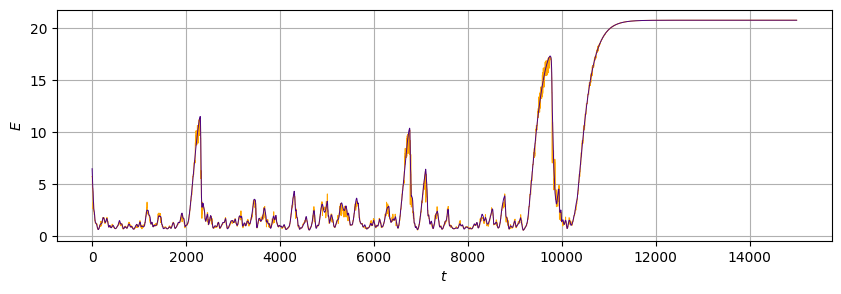

In [35]:
plt.figure(figsize=(10,3))
ek_ku1_t1 = show_energy_clustering(clust_ku_1, assign_ku_1, 'orange')
ek_t1 = show_energy(trajectory, '#4B0082')
plt.grid()
plt.show()

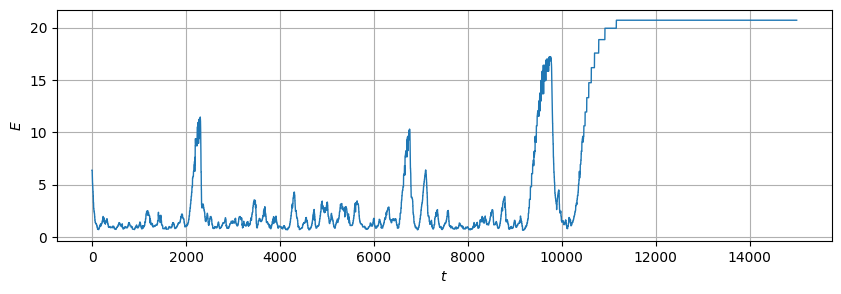

In [23]:
plt.figure(figsize=(10,3))
ek_kk = show_energy_clustering(clust_kk_1, assign_kk_1, None)
plt.grid()
plt.show()

In [20]:
assign_test1_ku1 = clust_ku_1.transform(tr_test1)

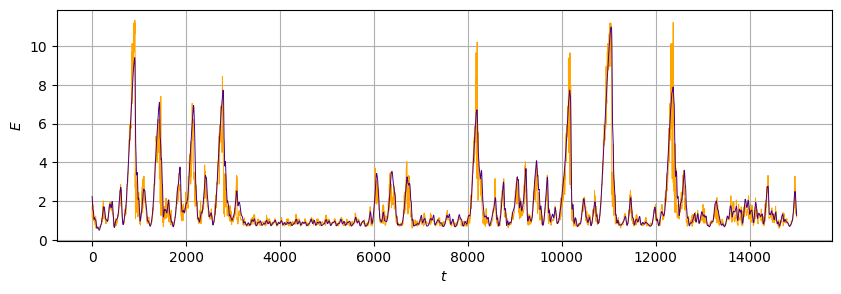

In [21]:
plt.figure(figsize=(10,3))
ek_ku1_t1 = show_energy_clustering(clust_ku_1, assign_test1_ku1, 'orange')
ek_t1 = show_energy(tr_test1, '#4B0082')
plt.grid()
plt.show()

In [52]:
def calc_mape(model, tr, clust, assign):
    mape = 0
    ek_tr = model.kinetic_energy(tr)
    tr_cl = np.zeros((len(assign), model.dim))
    for i in range(len(assign)):
        if assign[i] == -1:
            tr_cl[i] = tr_cl[i-1] 
        else:
            tr_cl[i] = clust.cluster_centers[assign[i]] 
    ek_discr = model.kinetic_energy(tr_cl)        

    for j in range(len(tr)):
        mape += abs(ek_tr[j] - ek_discr[j])/abs(ek_tr[j])
                                                
    return mape/len(tr) * 100

mape = calc_mape(model, tr_test1, clust_ku_1, assign_test1_ku1)

In [26]:
assign_test2_ku1 = clust_ku_1.transform(tr_test2)

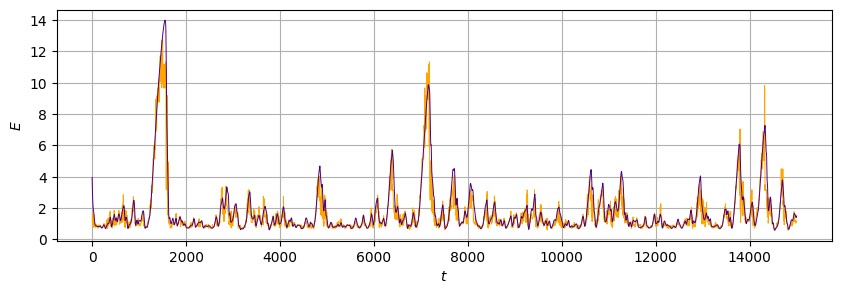

In [27]:
plt.figure(figsize=(10,3))
ek_ku1_t1 = show_energy_clustering(clust_ku_1, assign_test2_ku1, 'orange')
ek_t1 = show_energy(tr_test2, '#4B0082')
plt.grid()
plt.show()

In [37]:
#Нахождение матрицы переходов
cur_assign = assign_ku_1
cur_clust = clust_ku_1

estimator_mlm = markov.msm.MaximumLikelihoodMSM(
    reversible=False,
    stationary_distribution_constraint=None
#     transition_matrix_tolerance = 1e-5
)

start_time = time.time()
msm = estimator_mlm.fit(cur_assign, lagtime=1).fetch_model()  # MSM для дискретной траектории
print("%s seconds" % (time.time() - start_time))

0.16402554512023926 seconds


In [39]:
# Генерация случайных н.у. в виде дискретного состояния
def random_ic_discr_state(m_size, clust):
    ic = random_initial_conditions(m_size)
    return clust.transform(np.array([ic]))

# Получение траекторий 
def msm_simulation(msm, m_size, time, clust):
    return msm.simulate(time, int(random_ic_discr_state(m_size, clust)[0]))

def get_relam_time(ke, T):
    start_time = None
    lam_time = None
    for t in range(len(ke)):
        if (start_time):
            if t - start_time > T:
                return t
            if ke[t] < 20:
                start_time = None
        elif ke[t] > 20:
            start_time = t
    if (start_time):
        lam_time = t 
    return lam_time

def get_energy_clustering(clustering, assignments, model):
    tr_cl = np.zeros((len(assignments), model.dim))
    for i in range(len(assignments)):
        if assignments[i] == -1:
            tr_cl[i] = tr_cl[i-1] 
        else:
            tr_cl[i] = clustering.cluster_centers[assignments[i]] 
    return model.kinetic_energy(tr_cl)

In [40]:
def survival_function(data, debug=False):
    values = sorted([t for t in data if t != None])
    if debug and len(data) != len(values):
        print(f'While building survival function, filtered {len(data) - len(values)} "None" points')
    probs = np.array([1 - i/len(values) for i in range(len(values))])
    return values, probs

def relaminarisation_time(ke, T=1000, debug=False):
    '''
    We detect turbulent-to-laminar transition if the kinetic energy is larger than 15 for more than T time units
    and return relaminarisation time is this event has occured. Otherwise None is returned
    '''
    transition_start = None
    for t in range(len(ke)):
        if transition_start:
            if t - transition_start > T:
                if debug:
                    print(f'Found turbulent-to-laminar transition from {transition_start} to {t}')
                return t
            if ke[t] < 20:
                transition_start = None
        elif ke[t] > 20:
            transition_start = t
    last_t = len(ke) - 1
    if debug and transition_start is not None:
        print(f'Found turbulent-to-laminar transition from {transition_start} to infty ({last_t})')
    return last_t if transition_start is not None else None

# Получение распределения времени жизни
def lifetime_distribution(msm, model, clust, n, time):
    T = 1000
    lam_times = []
    for i in range(n):
        tr = msm_simulation(msm, model.dim, time, clust)
        ke = get_energy_clustering(clust, tr, model)
#         lam_times.append(get_relam_time(ke, T))
        lam_times.append(relaminarisation_time(ke, T))
    return lam_times

In [41]:
start_time = time.time()
lam_times = lifetime_distribution(msm, model, cur_clust, 1000, 2000) #1000, 20000
print("%s seconds" % (time.time() - start_time))

20.950587511062622 seconds


While building survival function, filtered 902 "None" points


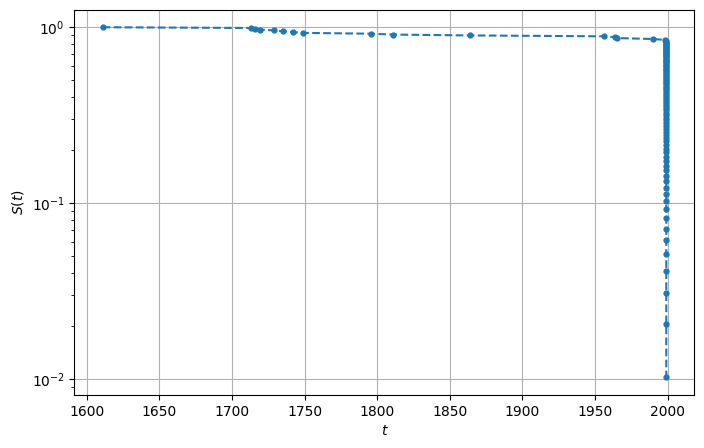

In [46]:
def show_lifetime_distribution(lam_times):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    sf = survival_function(lam_times, True)
    lines = ax.semilogy(sf[0], sf[1], 'o--', linewidth=1.5, markersize=3.5)

    ax.grid()
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$S(t)$')
    plt.show()
    
show_lifetime_distribution(lam_times)

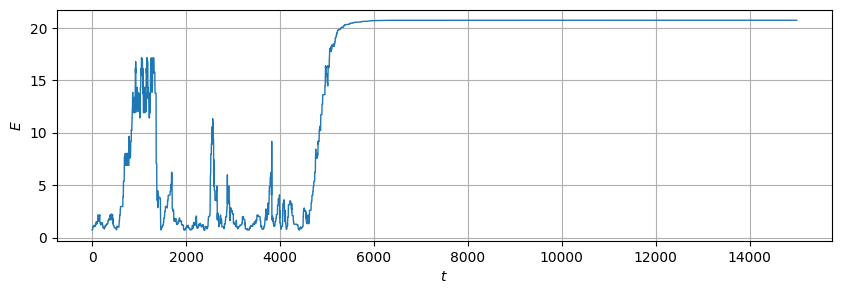

In [47]:
ic = random_ic_discr_state(model.dim, cur_clust)
msm_t = msm.simulate(15000, ic)
plt.figure(figsize=(10,3))
show_energy_clustering(cur_clust, msm_t, '')
plt.grid()
plt.show()

In [79]:
# Получение распределения на n шагов

n=300 # Число шагов
step = 1 # Шаг сетки для кинетической энергии
# prec = 0 
tr_assignments = assign_ku_1 # Траектория
clustering = clust_ku_1 # Кластеры
start = 0 # Начальное состояние (t)

In [65]:
# Получение кинетической энергии каждого состояния

def get_ek_trajectory(model, trajectory, tr_assignments):
    ek_states = np.zeros(1000)
    ek_trajectory = model.kinetic_energy(trajectory)
    for i in range(len(tr_assignments)):
        ek_states[tr_assignments[i]] = ek_trajectory[i]
    return ek_states, ek_trajectory

# ek_states = get_ek_trajectory(model, trajectory, tr_assignments)


In [58]:
def calc_expectation(p, a):
    ex = 0
    for i in range(len(a)):
        ex += p[i] * a[i]
    return ex

In [82]:
def get_distribution_ek(n, model, trajectory, msm, tr_assignments, clustering, start):
    expectation = np.zeros(n) # Математическое ожидаение
    ek_states, ek_trajectory = get_ek_trajectory(model, trajectory, tr_assignments)
    
    p0 = np.zeros(len(msm.transition_matrix)) # Начальное распределение
    p0[tr_assignments[start]] = 1.

    p = np.zeros((n, len(msm.transition_matrix))) # Массив распределений вероятности

    ek_i = np.zeros((n+1, int(ek_states.max()/step)+1)) # Массив вероятностей, соответствующих уровням кинетической энергии
    ek_i[0][int(ek_states[tr_assignments[start]]*1/step)] = p0[tr_assignments[start]]

    p[0] = p0
    for i in range(n):
        p0 = msm.propagate(p0, 1)
        p[i] = p0
        for s in range(len(p0)):
            if p0[s] != 0:
                ek_i[i+1][int(ek_states[s]*1/step)] += p0[s]
        expectation[i] = calc_expectation(p0, ek_states)
    return ek_i, expectation, ek_trajectory

In [85]:
def show_distribution_ek(n, model, trajectory, msm, tr_assignments, clustering, start):
    
    ek_i, expectation, ek_trajectory = get_distribution_ek(n, model, trajectory, msm, tr_assignments, clustering, start)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    tr_clust = np.zeros((len(tr_assignments), model.dim))
    for i in range(len(tr_assignments)): 
        tr_clust[i] = clustering.cluster_centers[tr_assignments[i]]
        ek_tr = model.kinetic_energy(tr_clust[start:n+start])

    ax.plot(np.arange(len(tr_clust[start:n+start])), ek_tr*1/step, "b--", linewidth=1, label = f'Дискретная траектория')
    ax.plot(np.arange(len(trajectory[start:n+start])), ek_trajectory[start:n+start]*1/step, "#00008B", linewidth=1, label = "Исходная траектория")
    ax.plot(np.arange(n), expectation*1/step, '#800000', linewidth=1, label = "Математическое ожидание")

    ax.set_xlabel('$t$')
    ax.set_ylabel('$E$')

    p1 = ax.imshow(np.transpose(ek_i), origin='lower', aspect='auto', cmap='Reds', alpha=0.9)
    plt.legend()

    axins = inset_axes(ax,
                       width="7%",
                       height="70%",
                       loc='lower left',
                       bbox_to_anchor=(1.05, 0., 1, 1),
                       bbox_transform=ax.transAxes,
                       )
    plt.colorbar(p1, ax=ax, cax=axins, label='Вероятность')

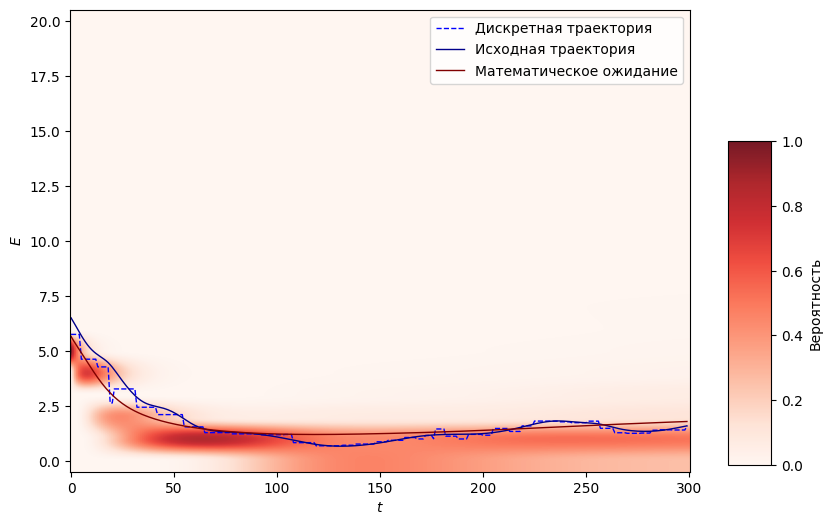

In [86]:
show_distribution_ek(n, model, trajectory, msm, tr_assignments, clustering, start)